In [1]:
pip install torchmetrics==0.5.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import GroupNormalizer, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.utils import profile
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
df_3 = pd.read_csv('TSC_Sales_Data.csv')
print(df_3.info())
df_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SCRUB_ITEM      70829 non-null  int64  
 1   TIME_DIM_KEY    70829 non-null  int64  
 2   SCRUB_TRANS_NO  70829 non-null  int64  
 3   TRANS_SEQ_NO    70829 non-null  int64  
 4   UNIT_QTY        70829 non-null  float64
 5   UNIT_PRICE      70829 non-null  float64
 6   UNIT_COST       70829 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.8 MB
None


,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,20180402,1296,2,2.0,322.99,132.97
1,1,20181206,6878,1,1.0,322.99,132.97
2,1,20181210,7010,2,2.0,322.99,132.97
3,1,20190214,8380,2,1.0,322.99,132.97
4,1,20190502,10639,1,2.0,219.99,132.97


### Extract Week, Month, Year from Time_Dim_Key

In [5]:
df_3['year'] = df_3['TIME_DIM_KEY']//10000
df_3['month'] = (df_3['TIME_DIM_KEY']//100)%100
df_3['day'] = df_3['TIME_DIM_KEY']%100
df_3['date'] = df_3['year'].astype(str) +'-'+df_3['month'].astype(str) +'-'+ df_3['day'].astype(str)
df_3['date'] = pd.to_datetime(df_3['date'])
df_3['weekday'] = df_3['date'].dt.week
df_3.head()

<ipython-input-5-6385570dbf68>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_3['weekday'] = df_3['date'].dt.week


,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST,year,month,day,date,weekday
0,1,20180402,1296,2,2.0,322.99,132.97,2018,4,2,2018-04-02,14
1,1,20181206,6878,1,1.0,322.99,132.97,2018,12,6,2018-12-06,49
2,1,20181210,7010,2,2.0,322.99,132.97,2018,12,10,2018-12-10,50
3,1,20190214,8380,2,1.0,322.99,132.97,2019,2,14,2019-02-14,7
4,1,20190502,10639,1,2.0,219.99,132.97,2019,5,2,2019-05-02,18


### Add time_ID as Year_Week

In [6]:
df_time = df_3.groupby(['year','weekday']).date.min().reset_index()
df_time = df_time[:-1]
df_time['time_id'] = 100*df_time['year'] + df_time['weekday']
df_time.head()

,year,weekday,date,time_id
0,2018,1,2018-01-01,201801
1,2018,2,2018-01-08,201802
2,2018,3,2018-01-15,201803
3,2018,4,2018-01-22,201804
4,2018,5,2018-01-29,201805


In [7]:
df_3['time_id'] = 100*df_3['year'] + df_3['weekday']
df_3['time_id'] = np.where(df_3['time_id'] == 202153, 202101, df_3['time_id'])
df_3.head()

,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST,year,month,day,date,weekday,time_id
0,1,20180402,1296,2,2.0,322.99,132.97,2018,4,2,2018-04-02,14,201814
1,1,20181206,6878,1,1.0,322.99,132.97,2018,12,6,2018-12-06,49,201849
2,1,20181210,7010,2,2.0,322.99,132.97,2018,12,10,2018-12-10,50,201850
3,1,20190214,8380,2,1.0,322.99,132.97,2019,2,14,2019-02-14,7,201907
4,1,20190502,10639,1,2.0,219.99,132.97,2019,5,2,2019-05-02,18,201918


### Aggregate Day level Data to Weekly Level

In [8]:
df = df_3.groupby(['SCRUB_ITEM','time_id']).agg({'UNIT_QTY':'sum','UNIT_PRICE':'mean','UNIT_COST':'mean'}).reset_index()
df.head()

,SCRUB_ITEM,time_id,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,201814,2.0,322.99,132.97
1,1,201849,1.0,322.99,132.97
2,1,201850,2.0,322.99,132.97
3,1,201901,1.0,199.99,132.97
4,1,201907,1.0,322.99,132.97


In [9]:
df = pd.merge(df,df_time, on = 'time_id', how = 'left')

In [10]:
df['date'] = pd.to_datetime(df['date'])

### Adding Fourier Features based on time to capture Seasonality

In [11]:
#fourier features
fourier = pd.DataFrame()
fourier['date'] = df['date']
fourier = fourier.drop_duplicates()
fourier = fourier.sort_values(by = 'date')
fourier = fourier.set_index(pd.PeriodIndex(fourier['date'],freq = 'W'))
fourier['sin365'] = np.sin(2*np.pi*fourier.index.dayofyear/52)
fourier['cos365'] = np.cos(2*np.pi*fourier.index.dayofyear/52)
fourier['sin365_2'] = np.sin(4*np.pi*fourier.index.dayofyear/52)
fourier['cos365_2'] = np.cos(4*np.pi*fourier.index.dayofyear/52)
fourier= fourier.rename(columns = {'date':'Date'})
fourier= fourier.reset_index()
fourier = fourier.drop('date',axis =1)
fourier= fourier.rename(columns = {'Date':'date'})
fourier.head()


In [14]:
df_1 = pd.merge(df,fourier, on = ['date'])
df_1.head()

,SCRUB_ITEM,time_id,UNIT_QTY,UNIT_PRICE,UNIT_COST,year,weekday,date,sin365,cos365,sin365_2,cos365_2
0,1,201814,2.0,322.99,132.97,2018,14,2018-04-02,-0.663123,0.748511,-0.992709,0.120537
1,7,201814,1.0,159.99,128.55,2018,14,2018-04-02,-0.663123,0.748511,-0.992709,0.120537
2,11,201814,1.0,559.99,440.99,2018,14,2018-04-02,-0.663123,0.748511,-0.992709,0.120537
3,19,201814,1.0,1999.99,1520.00,2018,14,2018-04-02,-0.663123,0.748511,-0.992709,0.120537
4,24,201814,1.0,99.99,62.99,2018,14,2018-04-02,-0.663123,0.748511,-0.992709,0.120537


### Calculate Margin for Lower Bound of Sales Price

In [15]:
# calcualte margin
df_w = df_1[df_1.year == 2021]
df_margin = df_w.groupby('SCRUB_ITEM')
df_margin = df_margin.agg({'UNIT_PRICE':'min','UNIT_COST':'min'}).reset_index()
df_margin['margin'] = 100*(df_margin['UNIT_PRICE'] - df_margin['UNIT_COST'])/df_margin['UNIT_COST']

In [16]:
df_margin['margin'].mean()

33.65736674437013

In [17]:
df_margin['margin'].max()

153.90611160318858

In [18]:
df_fourier = df_1.groupby('weekday')
df_fourier = df_fourier[['sin365','cos365','sin365_2','cos365_2']].mean().reset_index()


In [19]:
df_1 = df_1.sort_values(by = ['time_id']).reset_index()

### Decompose Sales into Trend And Seasonality

In [46]:
groups = df_1.groupby('SCRUB_ITEM')
seasonal = {}
m = 0
for grp in groups:
    x = grp[1]
    x['date'] = pd.to_datetime(x['date'])
    #tdi = pd.DatetimeIndex(x.date)
    #x.set_index(tdi, inplace=True)
    x = x.set_index(x['time_id'])
    additional_decom = seasonal_decompose(x['UNIT_QTY'],model = 'additive',period=int(len(x)/3.5))
    seasonal[grp[0]] = additional_decom
list_item = df_1['SCRUB_ITEM'].unique()

In [51]:
df_trend = pd.DataFrame(columns = ['time_id', 'SCRUB_ITEM', 'trend', 'seasonality'])
for x in list_item:
    p = seasonal[x]
    df_x = pd.DataFrame(columns = ['SCRUB_ITEM','trend','seasonality'])
    #print(x)
    #df_x['time_id'] = p.trend.index
    df_x['trend'] = p.trend
    df_x['seasonality'] = p.seasonal
    df_x['trend'] = df_x['trend'].fillna(method = 'backfill')
    df_x['trend'] = df_x['trend'].fillna(method = 'ffill')
    df_x['seasonality'] = df_x['seasonality'].fillna(method = 'backfill')
    df_x['seasonality'] = df_x['seasonality'].fillna(method = 'ffill')
    df_x['SCRUB_ITEM'] = x
    df_x = df_x.reset_index()
    df_trend = pd.concat([df_trend,df_x])

In [53]:
df_2 = pd.merge(df_1,df_trend, on = ['SCRUB_ITEM','time_id'])
len(df_2)/len(df_1)

1.0

In [54]:
data = df_2
data["time_idx"] = (data["year"]-2018)*52 + data["weekday"]
data_min= data.groupby('SCRUB_ITEM').time_idx.min().reset_index()
data_min.columns = ['SCRUB_ITEM','time_idx_min']
data_1 = pd.merge(data,data_min, on = 'SCRUB_ITEM')
data_1['time_idx'] =data_1['time_idx'] - data_1['time_idx_min']

### Train TFT Model for forecasting Sales

In [62]:
training_cutoff = data["time_idx"].max() - 6
max_encoder_length = 180
max_prediction_length = 6
data = data_1
data['SCRUB_ITEM'] = data['SCRUB_ITEM'].astype(str)
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="trend",
    group_ids=['SCRUB_ITEM'],
    min_encoder_length=max_encoder_length // 2,  # allow encoder lengths from 0 to max_prediction_length
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["SCRUB_ITEM"],
    static_reals=[],
    time_varying_known_reals=['year','weekday','sin365','cos365'],
    time_varying_unknown_reals=['trend'],
    target_normalizer=GroupNormalizer(
        groups=['SCRUB_ITEM'], transformation="softplus", center=False
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 10 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__SCRUB_ITEM': '22'}, {'__group_id__SCRUB_ITEM': '25'}, {'__group_id__SCRUB_ITEM': '26'}, {'__group_id__SCRUB_ITEM': '4'}, {'__group_id__SCRUB_ITEM': '60'}, {'__group_id__SCRUB_ITEM': '67'}, {'__group_id__SCRUB_ITEM': '8'}, {'__group_id__SCRUB_ITEM': '84'}, {'__group_id__SCRUB_ITEM': '9'}, {'__group_id__SCRUB_ITEM': '96'}]
  warnings.warn(
/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 12 series/groups which therefore are not present in the dat

In [63]:
early_stop_callback = EarlyStopping(monitor="train_SMAPE", min_delta=0.005, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="full",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger = logger
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [64]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=20,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=20,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Number of parameters in network: 50.5k


/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:817: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

    | Name                                                                                      | Type                            | Params
------------------------------------------------------------------------------------------------------------------------------------------------
0   | loss                                                                                      | QuantileLoss                    | 0     
1   | logging_metrics                                                                           | ModuleList                      | 0     
2   | logging_metrics.0                                                                         | SMAPE                           | 0     


/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Restoring states from the checkpoint file at /Users/parul/Downloads/PriceOptimizationc6dad82/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /Users/parul/Downloads/PriceOptimizationc6dad82/lr_find_temp_model.ckpt


suggested learning rate: 5.88843655355589e-05


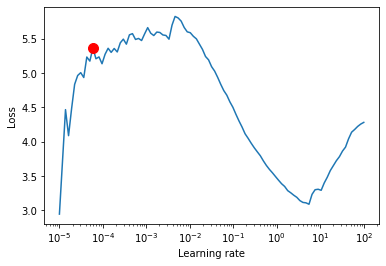

<ipython-input-65-20232e7f9faa>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [65]:
# find optimal learning rate
# remove logging and artificial epoch size
tft.hparams.log_interval = -1
tft.hparams.log_val_interval = -1
trainer.limit_train_batches = 1.0
# run learning rate finder
res = trainer.tuner.lr_find(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
tft.hparams.learning_rate = res.suggestion()



In [66]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

# make a prediction on entire validation set
#preds, index = tft.predict(val_dataloader, return_index=True, fast_dev_run=True)

/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

    | Name                                                                                      | Type                            | Params
------------------------------------------------------------------------------------------------------------------------------------------------
0   | loss                                                                                      | QuantileLoss                    | 0     
1   | logging_metrics                                                                           | ModuleList                      | 0     
2   | logging_metrics.0                                                                         | SMAPE                           | 0     
3 

In [78]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [79]:
actuals = torch.cat([y for x,(y,weight) in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
act = actuals.numpy()
pred = predictions.numpy()


In [82]:
(actuals - predictions).abs().mean().item()

0.3794829845428467

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(act,pred)

5.746308341622353

### Predicting for Next 12 Weeks

In [89]:
start = df_1[df_1.year == 2021].weekday.max()

In [103]:
df_future = pd.DataFrame()
df_future['SCRUB_ITEM'] = df_1.SCRUB_ITEM.unique()
Weeks = list(np.arange(start+1, start+13))
df_future['weekday'] = [Weeks for _ in range(len(df_future))]
df_future = df_future.explode('weekday').reset_index(drop = True)
df_future['year'] = 2021


In [104]:
df_fourier = df_1.groupby('weekday')
df_fourier = df_fourier[['sin365','cos365','sin365_2','cos365_2']].mean().reset_index()
df_future =  pd.merge(df_future,df_fourier, on = ['weekday'])


In [105]:
df_future.weekday = df_future.weekday.astype(int)

In [106]:
df_future["time_idx"] = (df_future["year"]-2018)*52 + df_future["weekday"]
df_future = pd.merge(df_future,data_min, on = 'SCRUB_ITEM')
df_future['time_idx'] =df_future['time_idx'] - df_future['time_idx_min']
df_future['trend'] = 0

In [107]:
encoder_data = data[df_future.columns]
encoder_data = encoder_data[(encoder_data.year == 2021) & (encoder_data.weekday >= start-8)]
df_predict = pd.concat([encoder_data,df_future])
df_predict.reset_index(inplace= True)

In [110]:

df_predict['SCRUB_ITEM'] = df_predict['SCRUB_ITEM'].astype(str)
forecast = TimeSeriesDataSet.from_dataset(training, df_predict,
                             min_prediction_length = 13, max_prediction_length = 13,max_encoder_length = 7,
                             min_encoder_length = 7)


/Users/parul/opt/anaconda3/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 30 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__SCRUB_ITEM': '10'}, {'__group_id__SCRUB_ITEM': '12'}, {'__group_id__SCRUB_ITEM': '14'}, {'__group_id__SCRUB_ITEM': '18'}, {'__group_id__SCRUB_ITEM': '22'}, {'__group_id__SCRUB_ITEM': '26'}, {'__group_id__SCRUB_ITEM': '31'}, {'__group_id__SCRUB_ITEM': '32'}, {'__group_id__SCRUB_ITEM': '34'}, {'__group_id__SCRUB_ITEM': '37'}]
  warnings.warn(


In [111]:
new_raw_predictions, new_x = best_tft.predict(forecast,mode = 'prediction', return_x = True)

In [112]:
df_idx = forecast.x_to_index(new_x)
df_idx['grp'] = df_idx.index
new_raw_predictions.numpy().shape
list_col = [x for x in range(0,13)]
raw_pred = new_raw_predictions.numpy()
df_pred_mean = pd.DataFrame(raw_pred)
df_pred_mean['grp'] = df_pred_mean.index
df_pred_mean1 = pd.merge(df_pred_mean, df_idx, on = ['grp'])
df_pred_mean2 = pd.melt(df_pred_mean1, id_vars=['SCRUB_ITEM','grp','time_idx'],value_vars = list_col)
x_ind = new_x['decoder_time_idx'].numpy()
df_ind = pd.DataFrame(x_ind)
df_ind['grp'] = df_ind.index
df_ind1 = pd.melt(df_ind, id_vars=['grp'],value_vars= list_col)
df_res = pd.merge(df_pred_mean2,df_ind1, on = ['grp','variable'])
df_res.columns = ['SCRUB_ITEM','grp','time_idx_start','Lag','Predicted','time_idx']

In [115]:
results_df = pd.merge(df_predict,df_res, on = ['SCRUB_ITEM','time_idx'])
results_df.Predicted = results_df.Predicted.abs()

In [117]:
ans_df = results_df[['SCRUB_ITEM','weekday','year','sin365', 'cos365',
       'sin365_2', 'cos365_2','Predicted']]
ans_df.head()

,SCRUB_ITEM,weekday,year,sin365,cos365,sin365_2,cos365_2,Predicted
0,2,30,2021,0.568065,0.822984,0.935016,0.354605,132.220352
1,2,31,2021,0.992709,0.120537,0.239316,-0.970942,132.500076
2,40,30,2021,0.568065,0.822984,0.935016,0.354605,80.831223
3,40,31,2021,0.992709,0.120537,0.239316,-0.970942,81.270668
4,40,31,2021,0.992709,0.120537,0.239316,-0.970942,80.744148


### Adding Seasonality to Forecasted Demand

In [118]:
seasona_trend = data.groupby(['SCRUB_ITEM','weekday']).seasonality.mean().reset_index()
ans_df_final = pd.merge(ans_df,seasona_trend, on =['SCRUB_ITEM','weekday'])
ans_df_final['Forecast_Sales'] = ans_df_final['Predicted'] + ans_df_final['seasonality']
ans_df_final.head()

,SCRUB_ITEM,weekday,year,sin365,cos365,sin365_2,cos365_2,Predicted,seasonality,Forecast_Sales
0,2,30,2021,0.568065,0.822984,0.935016,0.354605,132.220352,75.820069,208.040421
1,2,31,2021,0.992709,0.120537,0.239316,-0.970942,132.500076,22.920559,155.420636
2,40,30,2021,0.568065,0.822984,0.935016,0.354605,80.831223,-34.188698,46.642525
3,40,31,2021,0.992709,0.120537,0.239316,-0.970942,81.270668,-12.853000,68.417668
4,40,31,2021,0.992709,0.120537,0.239316,-0.970942,80.744148,-12.853000,67.891148


In [127]:
ans_x = ans_df_final[['SCRUB_ITEM','weekday','year','Forecast_Sales','sin365','cos365']]
ans_x.columns = ['SCRUB_ITEM','weekday','year','UNIT_QTY','sin365','cos365']
ans_x.head()

,SCRUB_ITEM,weekday,year,UNIT_QTY,sin365,cos365
0,2,30,2021,208.040421,0.568065,0.822984
1,2,31,2021,155.420636,0.992709,0.120537
2,40,30,2021,46.642525,0.568065,0.822984
3,40,31,2021,68.417668,0.992709,0.120537
4,40,31,2021,67.891148,0.992709,0.120537


In [126]:
data_ans.head()


,SCRUB_ITEM,weekday,year,UNIT_QTY,sin365,cos365
0,2,1,2018,3.0,7.485107e-01,6.631227e-01
1,2,52,2018,13.0,-1.714506e-15,1.000000e+00
2,2,1,2019,21.0,6.631227e-01,7.485107e-01
3,2,2,2019,11.0,1.000000e+00,-1.608123e-16
4,2,3,2019,32.0,6.631227e-01,-7.485107e-01


In [128]:
data_ans = data[['SCRUB_ITEM','weekday','year','UNIT_QTY','sin365','cos365']]
ans_x = pd.concat([data_ans,ans_x])
ans_x.head()

,SCRUB_ITEM,weekday,year,UNIT_QTY,sin365,cos365
0,2,1,2018,3.0,7.485107e-01,6.631227e-01
1,2,52,2018,13.0,-1.714506e-15,1.000000e+00
2,2,1,2019,21.0,6.631227e-01,7.485107e-01
3,2,2,2019,11.0,1.000000e+00,-1.608123e-16
4,2,3,2019,32.0,6.631227e-01,-7.485107e-01


In [129]:
ans_x.to_csv('TSC_sales_forecast.csv',index = False)